In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random
import time
import codecs
import sys

# (restrict tensorflow memory growth)
os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True

In [2]:
# neural network parameters
mb_size = 256
h_Q_dim = 512
h_P_dim = 512

c = 0
lr = 1e-4

# problem dimensions
dim = 3
dataElements = dim+3*3+2*dim # sample (6D), gap1 (2D, 1D orientation), gap2, gap3, init (6D), goal (6D)

z_dim = 3 # latent
X_dim = dim # samples
y_dim = dim # reconstruction of the original point
c_dim = dataElements - dim # dimension of conditioning variable

In [3]:
# read in data from csv
filename = r'NarrowDataFile_omni.csv'
f = open(filename, 'rb')

# csv.field_size_limit(sys.maxsize)
reader = csv.reader(codecs.iterdecode(f, 'utf-8-sig'))
count = 0
data_list = []
for row in reader:
    data_list.append(row[:dataElements])
f.close()

data = np.array(data_list, dtype='d')
numEntries = data.shape[0]
# print(data[:4,:])


In [4]:
# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)

ratioTestTrain = 0.8
numTrain = int(numEntries*ratioTestTrain)

X_train = data[:numTrain,:dim] # state: x, y, z, xdot, ydot, zdot
c_train = data[:numTrain,dim:dataElements] # conditions: gaps, init (6), goal (6)

X_test = data[numTrain:numEntries,:dim]
c_test = data[numTrain:numEntries,dim:dataElements]
numTest = X_test.shape[0]

In [5]:
# change conditions to occupancy grid
def isSampleFree(sample, obs):
    for o in range(0,int(obs.shape[0]/(2*dimW))):
        isFree = 0
        for d in range(0,sample.shape[0]):
            if (sample[d] < obs[2*dimW*o + d] or sample[d] > obs[2*dimW*o + d + dimW]):
                isFree = 1
                break
        if isFree == 0:
            return 0
    return 1

gridSize = 11
dimW = 3
plotOn = False

# process data into occupancy grid
conditions = data[0:numEntries,dim:dataElements]
conditionsOcc = np.zeros([numEntries,gridSize*gridSize])
occGridSamples = np.zeros([gridSize*gridSize, 2])
gridPointsRange = np.linspace(0,1,num=gridSize)

idx = 0
for i in gridPointsRange:
    for j in gridPointsRange:
        occGridSamples[idx,0] = i
        occGridSamples[idx,1] = j
        idx += 1

start = time.time()
for j in range(0,numEntries,1):
    dw = 0.1
    dimW = 3
    gap1 = conditions[j,0:3]
    gap2 = conditions[j,3:6]
    gap3 = conditions[j,6:9]
    init = conditions[j,9:15]
    goal = conditions[j,15:21]

    obs1 = [0, gap1[1]-dw, -0.5,             gap1[0], gap1[1], 1.5]
    obs2 = [gap2[0]-dw, 0, -0.5,             gap2[0], gap2[1], 1.5];
    obs3 = [gap2[0]-dw, gap2[1]+dw, -0.5,    gap2[0], 1, 1.5];
    obs4 = [gap1[0]+dw, gap1[1]-dw, -0.5,    gap3[0], gap1[1], 1.5];
    obs5 = [gap3[0]+dw, gap1[1]-dw, -0.5,    1, gap1[1], 1.5];
    obs = np.concatenate((obs1, obs2, obs3, obs4, obs5), axis=0)
    
    if j % 10000 == 0:
        print('Iter: {}'.format(j))
        
    occGrid = np.zeros(gridSize*gridSize)
    for i in range(0,gridSize*gridSize):
        occGrid[i] = isSampleFree(occGridSamples[i,:],obs)
    conditionsOcc[j,:] = occGrid
    
    if plotOn:
        fig1 = plt.figure(figsize=(10,6), dpi=80)
        ax1 = fig1.add_subplot(111, aspect='equal')
        for i in range(0,obs.shape[0]/(2*dimW)): # plot obstacle patches
            ax1.add_patch(
            patches.Rectangle(
                (obs[i*2*dimW], obs[i*2*dimW+1]),   # (x,y)
                obs[i*2*dimW+dimW] - obs[i*2*dimW],          # width
                obs[i*2*dimW+dimW+1] - obs[i*2*dimW+1],          # height
                alpha=0.6
            ))
        for i in range(0,gridSize*gridSize): # plot occupancy grid
            if occGrid[i] == 0:
                plt.scatter(occGridSamples[i,0], occGridSamples[i,1], color="red", s=70, alpha=0.8)
            else:
                plt.scatter(occGridSamples[i,0], occGridSamples[i,1], color="green", s=70, alpha=0.8)
        plt.show()
end = time.time()
print('Time: ', end-start)
    
cs = np.concatenate((data[0:numEntries,dim+3*dimW:dataElements], conditionsOcc), axis=1) # occ, init, goal
c_dim = cs.shape[1]
c_gapsInitGoal = c_test
c_train = cs[0:numTrain,:] 
c_test = cs[numTrain:numEntries,:]

Iter: 0
Iter: 10000
Iter: 20000
Iter: 30000
Iter: 40000
Iter: 50000
Iter: 60000
Iter: 70000
Iter: 80000
Time:  26.53858208656311


In [6]:
# define networks
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
X = tf.placeholder(tf.float32, shape=[None, X_dim])
c = tf.placeholder(tf.float32, shape=[None, c_dim])

# Q
inputs_Q = tf.concat(axis=1, values=[X,c])

dense_Q1 = tf.layers.dense(inputs=inputs_Q, units=h_Q_dim, activation=tf.nn.relu)
dropout_Q1 = tf.layers.dropout(inputs=dense_Q1, rate=0.5)
dense_Q2 = tf.layers.dense(inputs=dropout_Q1, units=h_Q_dim, activation=tf.nn.relu)

z_mu = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_mu
z_logvar = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_logvar

# P
eps = tf.random_normal(shape=tf.shape(z_mu))
z = z_mu + tf.exp(z_logvar / 2) * eps
inputs_P = tf.concat(axis=1, values=[z,c])

dense_P1 = tf.layers.dense(inputs=inputs_P, units=h_P_dim, activation=tf.nn.relu)
dropout_P1 = tf.layers.dropout(inputs=dense_P1, rate=0.5)
dense_P2 = tf.layers.dense(inputs=dropout_P1, units=h_P_dim, activation=tf.nn.relu)

y = tf.layers.dense(inputs=dense_P2, units=X_dim) # fix to also output y

# training
w = [[1, 1, 0.5]]
recon_loss = tf.losses.mean_squared_error(labels=X, predictions=y, weights=w)
# TODO: fix loss function for angles going around
kl_loss = 10**-4 * 2 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

cvae_loss = tf.reduce_mean(kl_loss + recon_loss)

train_step = tf.train.AdamOptimizer(lr).minimize(cvae_loss)

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
it = 0

Instructions for updating:
non-resource variables are not supported in the long term




C:\Users\vishw\AppData\Local\Temp\ipykernel_31176\3600905627.py:10: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  dense_Q1 = tf.layers.dense(inputs=inputs_Q, units=h_Q_dim, activation=tf.nn.relu)
C:\Users\vishw\AppData\Local\Temp\ipykernel_31176\3600905627.py:11: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  dropout_Q1 = tf.layers.dropout(inputs=dense_Q1, rate=0.5)
C:\Users\vishw\AppData\Local\Temp\ipykernel_31176\3600905627.py:12: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  dense_Q2 = tf.layers.dense(inputs=dropout_Q1, units=h_Q_dim, activation=tf.nn.relu)
C:\Users\vishw\AppData\Local\Temp\ipykernel_31176\3600905627.py:14: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.ker

In [7]:
for it in range(it,it+500001):
    # randomly generate batches
    batch_elements = [randint(0,numTrain-1) for n in range(0,mb_size)]
    X_mb = X_train[batch_elements,:]
    c_mb = c_train[batch_elements,:]

    _, loss = sess.run([train_step, cvae_loss], feed_dict={X: X_mb, c: c_mb})

    if it % 10000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()

Iter: 0
Loss: 1.071

Iter: 10000
Loss: 0.004605

Iter: 20000
Loss: 0.004131

Iter: 30000
Loss: 0.004698

Iter: 40000
Loss: 0.003953

Iter: 50000
Loss: 0.004263

Iter: 60000
Loss: 0.003998

Iter: 70000
Loss: 0.003988

Iter: 80000
Loss: 0.003935

Iter: 90000
Loss: 0.004088

Iter: 100000
Loss: 0.003929

Iter: 110000
Loss: 0.003914

Iter: 120000
Loss: 0.003869

Iter: 130000
Loss: 0.003942

Iter: 140000
Loss: 0.003983

Iter: 150000
Loss: 0.003774

Iter: 160000
Loss: 0.003814

Iter: 170000
Loss: 0.003795

Iter: 180000
Loss: 0.003857

Iter: 190000
Loss: 0.003812

Iter: 200000
Loss: 0.003745

Iter: 210000
Loss: 0.003754

Iter: 220000
Loss: 0.003856

Iter: 230000
Loss: 0.003683

Iter: 240000
Loss: 0.003688

Iter: 250000
Loss: 0.003711

Iter: 260000
Loss: 0.003756

Iter: 270000
Loss: 0.003698

Iter: 280000
Loss: 0.003702

Iter: 290000
Loss: 0.003753

Iter: 300000
Loss: 0.003708

Iter: 310000
Loss: 0.003727

Iter: 320000
Loss: 0.003819

Iter: 330000
Loss: 0.003685

Iter: 340000
Loss: 0.003739

It

In [8]:
from map_2d import Map2D
import networkx as nx

8271


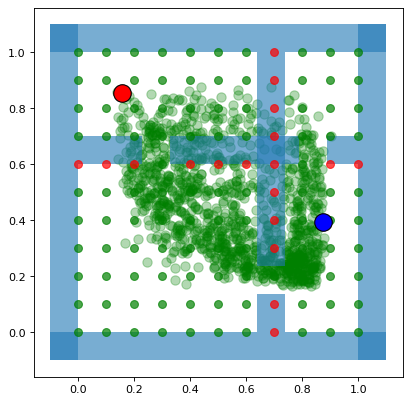

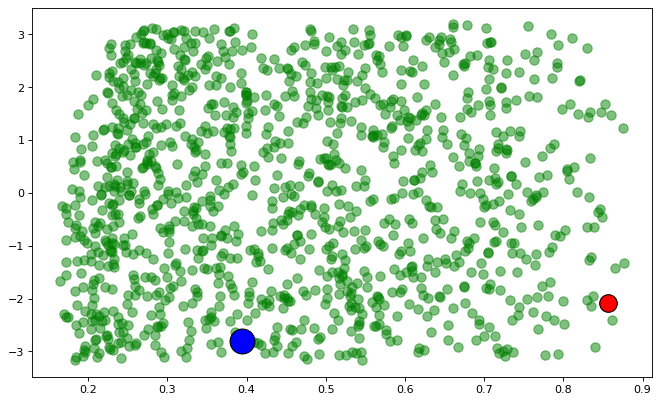

In [9]:
## Testing the model
# plot the latent space
num_viz = 1200

vizIdx = randint(0,numTest-1);
print(vizIdx)
vizIdx = 4291
c_sample_seed = c_test[vizIdx,:]
c_sample = np.repeat([c_sample_seed],num_viz,axis=0)
c_viz = c_gapsInitGoal[vizIdx,:]

# directly sample from the latent space (preferred, what we will use in the end)
y_viz, z_viz = sess.run([y, z], feed_dict={z: np.random.randn(num_viz, z_dim), c: c_sample})

fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect='equal')

plt.scatter(y_viz[:,0],y_viz[:,1], color="green", s=70, alpha=0.3)

dw = 0.1
dimW = 3
gap1 = c_viz[0:3]
gap2 = c_viz[3:6]
gap3 = c_viz[6:9]
init = c_viz[9:12]
goal = c_viz[12:15]

obs1 = [0, gap1[1]-dw, -0.5,             gap1[0], gap1[1], 1.5]
obs2 = [gap2[0]-dw, 0, -0.5,             gap2[0], gap2[1], 1.5];
obs3 = [gap2[0]-dw, gap2[1]+dw, -0.5,    gap2[0], 1, 1.5];
obs4 = [gap1[0]+dw, gap1[1]-dw, -0.5,    gap3[0], gap1[1], 1.5];
obs5 = [gap3[0]+dw, gap1[1]-dw, -0.5,    1, gap1[1], 1.5];
obsBounds = [-0.1, -0.1, -0.5, 0, 1.1, 1.5,
            -0.1, -0.1, -0.5, 1.1, 0, 1.5,
            -0.1, 1, -0.5, 1.1, 1.1, 1.5,
            1, -0.1, -0.5, 1.1, 1.1, 1.5,]
obstacles = []

obs = np.concatenate((obs1, obs2, obs3, obs4, obs5, obsBounds), axis=0)
for i in range(0,int(obs.shape[0]/(2*dimW))):
    ax1.add_patch(
    patches.Rectangle(
        (obs[i*2*dimW], obs[i*2*dimW+1]),   # (x,y)
        obs[i*2*dimW+dimW] - obs[i*2*dimW],          # width
        obs[i*2*dimW+dimW+1] - obs[i*2*dimW+1],          # height
        alpha=0.6
    ))
    leftbottom = (obs[i*2*dimW], obs[i*2*dimW+1])
    w = obs[i*2*dimW+dimW] - obs[i*2*dimW]
    h = obs[i*2*dimW+dimW+1] - obs[i*2*dimW+1]
    lefttop = (obs[i*2*dimW], obs[i*2*dimW+1] + h)
    righttop = (obs[i*2*dimW]+w, obs[i*2*dimW+1] + h)
    rightbottom = (obs[i*2*dimW]+w, obs[i*2*dimW+1])
    obstacles.append([leftbottom,lefttop,righttop,rightbottom])
    
for i in range(0,gridSize*gridSize): # plot occupancy grid
    cIdx = i + 2*dim
    if c_sample_seed[cIdx] == 0:
        plt.scatter(occGridSamples[i,0], occGridSamples[i,1], color="red", s=50, alpha=0.7)
    else:
        plt.scatter(occGridSamples[i,0], occGridSamples[i,1], color="green", s=50, alpha=0.7)

plt.scatter(init[0], init[1], color="red", s=250, edgecolors='black') # init
plt.scatter(goal[0], goal[1], color="blue", s=250, edgecolors='black') # goal

plt.show()

plt.figure(figsize=(10,6), dpi=80)
viz1 = 1;
viz2 = 2;
plt.scatter(y_viz[:,viz1],y_viz[:,viz2], color="green", s=70, alpha=0.5)
plt.scatter(c_viz[viz1+9],c_viz[viz2+9], color="red", s=250, edgecolors='black') # init
plt.scatter(c_viz[viz1+9+dim],c_viz[viz2+9+dim], color="blue", s=500, edgecolors='black') # goal
plt.show()

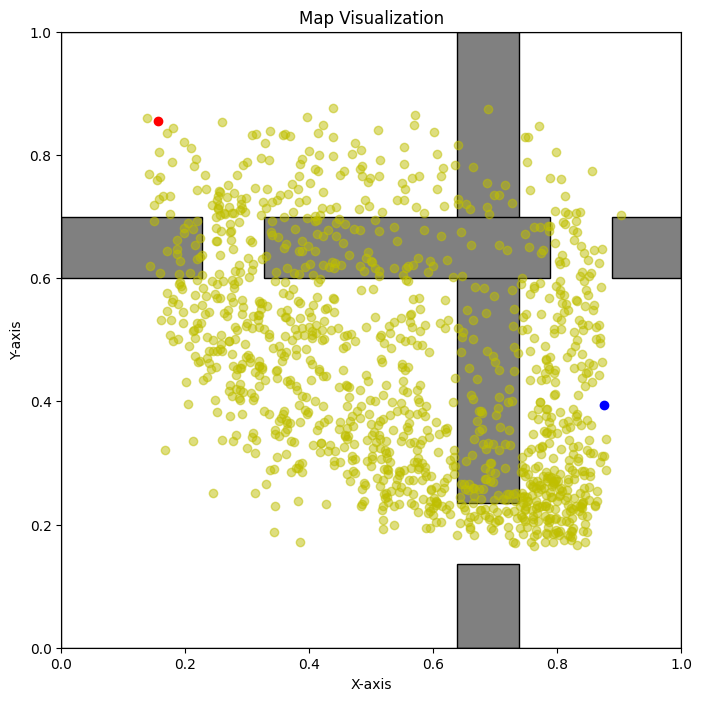

In [10]:
from map_2d import Map2D
import networkx as nx

map_2d = Map2D(obstacles)
ax, fig = map_2d.visualize_map(return_ax=True)
x_vals = [point[0] for point in y_viz]
y_vals = [point[1] for point in y_viz]
ax.scatter(x_vals, y_vals,  color='y', alpha=0.5)
ax.scatter([init[0]],[init[1]],color='r')
ax.scatter(goal[0],goal[1],color='b')



In [11]:
from robot import PointRobot, OmnidirectionalRobot, KinematicChain
from RRT import RRT
from PRM import PRM
from planner import Planner

The constructed graph has 1302 of nodes
The path length is 1.57


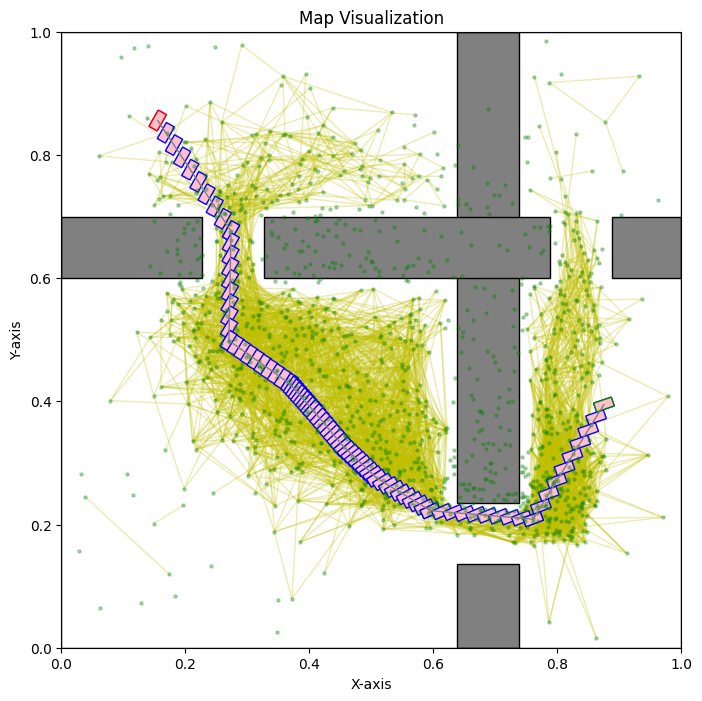

In [12]:
# Combining the CVAE samples with uniform samples to get a solution

#Define the robot with start and goal configurations
robot = OmnidirectionalRobot(width=0.015, height=0.030)

decoder_samples = list(map(tuple, y_viz[:,[0,1,2]].tolist()))

method = PRM(sampling_method="uniform", n_configs=100, kdtree_d=0.2, samples=decoder_samples)

planner = Planner(method, map_2d, robot)

planner.plan((init[0],init[1],init[2]), (goal[0],goal[1],goal[2]))
planner.visualize(make_video=False)

No path found


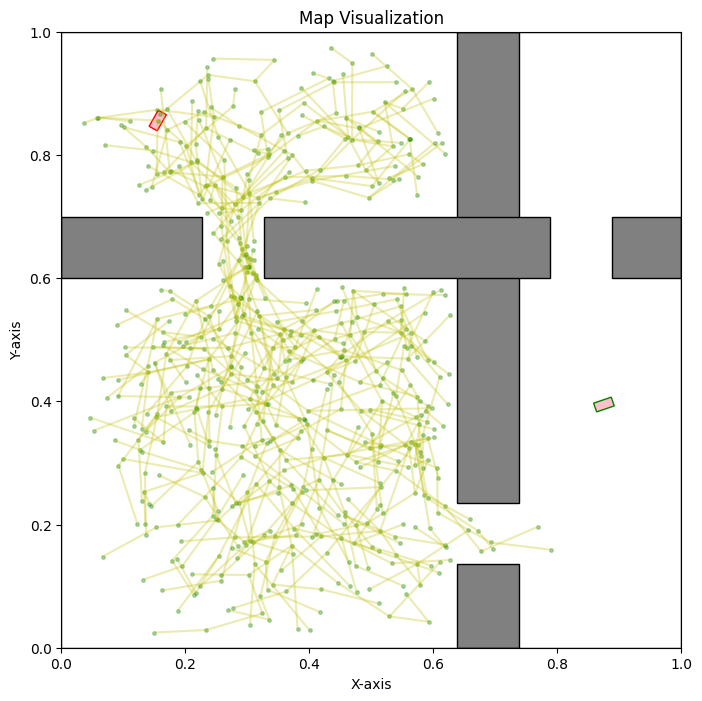

In [13]:
## Checking Solution with RRT*

method = RRT(sampling_method="RRT_star", n_configs=600, kdtree_d=0.1)
planner = Planner(method, map_2d, robot)

planner.plan((init[0],init[1],init[2]), (goal[0],goal[1],goal[2]))
planner.visualize(make_video=False)

In [14]:
# Function to find solution with CVAE and RRT*

def draw_results(num_viz=300):
    # num_viz = 100
    vizIdx = randint(0,numTest-1);
    print(vizIdx)
    # vizIdx = 12142
    c_sample_seed = c_test[vizIdx,:]
    c_sample = np.repeat([c_sample_seed],num_viz,axis=0)
    c_viz = c_gapsInitGoal[vizIdx,:]

    # directly sample from the latent space (preferred, what we will use in the end)
    y_viz, z_viz = sess.run([y, z], feed_dict={z: np.random.randn(num_viz, z_dim), c: c_sample})

    dw = 0.1
    dimW = 3
    gap1 = c_viz[0:3]
    gap2 = c_viz[3:6]
    gap3 = c_viz[6:9]
    start = c_viz[9:12]
    goal = c_viz[12:15]

    obs1 = [0, gap1[1]-dw, -0.5,             gap1[0], gap1[1], 1.5]
    obs2 = [gap2[0]-dw, 0, -0.5,             gap2[0], gap2[1], 1.5];
    obs3 = [gap2[0]-dw, gap2[1]+dw, -0.5,    gap2[0], 1, 1.5];
    obs4 = [gap1[0]+dw, gap1[1]-dw, -0.5,    gap3[0], gap1[1], 1.5];
    obs5 = [gap3[0]+dw, gap1[1]-dw, -0.5,    1, gap1[1], 1.5];
    obstacles = []

    obs = np.concatenate((obs1, obs2, obs3, obs4, obs5), axis=0)
    for i in range(0,int(obs.shape[0]/(2*dimW))):
        leftbottom = (obs[i*2*dimW], obs[i*2*dimW+1])
        w = obs[i*2*dimW+dimW] - obs[i*2*dimW]
        h = obs[i*2*dimW+dimW+1] - obs[i*2*dimW+1]
        lefttop = (obs[i*2*dimW], obs[i*2*dimW+1] + h)
        righttop = (obs[i*2*dimW]+w, obs[i*2*dimW+1] + h)
        rightbottom = (obs[i*2*dimW]+w, obs[i*2*dimW+1])
        obstacles.append([leftbottom,lefttop,righttop,rightbottom])

    map_2d = Map2D(obstacles)
    robot = OmnidirectionalRobot(width=0.015, height=0.030)

    print("Decoder sol")
    decoder_samples = list(map(tuple, y_viz[:,[0,1,2]].tolist()))
    start_time = time.time()
    method = PRM(sampling_method="uniform", n_configs=100, kdtree_d=0.2, samples=decoder_samples)
    planner = Planner(method, map_2d, robot)
    decoder_sol, decoder_len = planner.plan(start, goal)
    # planner.visualize(make_video=False)
    # return None, None
    end_time = time.time()
    elapsed_time_decoder = end_time - start_time

    # try:
    print("\nRRT* sol")
    start_time = time.time()
    method = RRT(sampling_method="RRT_star", n_configs=600, kdtree_d=0.2)
    # method = PRM(sampling_method="uniform", n_configs=100, kdtree_d=0.15, samples=decoder_samples)
    planner = Planner(method, map_2d, robot)
    rrt_sol, rrt_len = planner.plan(start, goal)
    # planner.visualize(make_video=False)
    end_time = time.time()
    elapsed_time_rrt = end_time - start_time
    print("\n")
    # except:
    #     return None,None

    if decoder_len == 0 or rrt_len == 0:
        return None, None

    return (decoder_len, rrt_len), (elapsed_time_decoder, elapsed_time_rrt)

In [15]:
from robot import PointRobot, OmnidirectionalRobot, KinematicChain
from RRT import RRT
from PRM import PRM
from planner import Planner


In [ ]:
## Take multiple iterations to compare the cost and execution time

costs = []
times = []
iter = []
i = 0
while i <= 1:
    cost, t = draw_results(500)
    costs.append(cost)
    times.append(t)
    iter.append(i+1)
    i = i+1

In [ ]:
# Plot the Cost comparision
plt.plot(iter, [t[0] for t in costs], marker='o', label='CVAE Solution Cost')
plt.plot(iter, [t[1] for t in costs], marker='s', label='RRT* Solution Cost')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.show()

In [34]:
# Function to find solution with CVAE and PRM for Time

def draw_results_time(num_viz=300):
    # num_viz = 100
    vizIdx = randint(0,numTest-1);
    print(vizIdx)
    # vizIdx = 12142
    c_sample_seed = c_test[vizIdx,:]
    c_sample = np.repeat([c_sample_seed],num_viz,axis=0)
    c_viz = c_gapsInitGoal[vizIdx,:]

    # directly sample from the latent space (preferred, what we will use in the end)
    y_viz, z_viz = sess.run([y, z], feed_dict={z: np.random.randn(num_viz, z_dim), c: c_sample})

    dw = 0.1
    dimW = 3
    gap1 = c_viz[0:3]
    gap2 = c_viz[3:6]
    gap3 = c_viz[6:9]
    start = c_viz[9:12]
    goal = c_viz[12:15]

    obs1 = [0, gap1[1]-dw, -0.5,             gap1[0], gap1[1], 1.5]
    obs2 = [gap2[0]-dw, 0, -0.5,             gap2[0], gap2[1], 1.5];
    obs3 = [gap2[0]-dw, gap2[1]+dw, -0.5,    gap2[0], 1, 1.5];
    obs4 = [gap1[0]+dw, gap1[1]-dw, -0.5,    gap3[0], gap1[1], 1.5];
    obs5 = [gap3[0]+dw, gap1[1]-dw, -0.5,    1, gap1[1], 1.5];
    obstacles = []

    obs = np.concatenate((obs1, obs2, obs3, obs4, obs5), axis=0)
    for i in range(0,int(obs.shape[0]/(2*dimW))):
        leftbottom = (obs[i*2*dimW], obs[i*2*dimW+1])
        w = obs[i*2*dimW+dimW] - obs[i*2*dimW]
        h = obs[i*2*dimW+dimW+1] - obs[i*2*dimW+1]
        lefttop = (obs[i*2*dimW], obs[i*2*dimW+1] + h)
        righttop = (obs[i*2*dimW]+w, obs[i*2*dimW+1] + h)
        rightbottom = (obs[i*2*dimW]+w, obs[i*2*dimW+1])
        obstacles.append([leftbottom,lefttop,righttop,rightbottom])

    map_2d = Map2D(obstacles)
    robot = OmnidirectionalRobot(width=0.015, height=0.030)

    print("Decoder sol")
    decoder_samples = list(map(tuple, y_viz[:,[0,1,2]].tolist()))
    start_time = time.time()
    method = PRM(sampling_method="uniform", n_configs=100, kdtree_d=0.2, samples=decoder_samples)
    planner = Planner(method, map_2d, robot)
    prm_sol, prm_len = planner.plan(start, goal)
    # planner.visualize(make_video=False)
    # return None, None
    end_time = time.time()
    elapsed_time_decoder = end_time - start_time
    print(f"Decoder Sol time {elapsed_time_decoder}")

    print("PRM sol")
    decoder_samples = list(map(tuple, y_viz[:,[0,1,2]].tolist()))
    start_time = time.time()
    method = PRM(sampling_method="uniform", n_configs=1000, kdtree_d=0.2, samples=[])
    planner = Planner(method, map_2d, robot)
    decoder_sol, decoder_len = planner.plan(start, goal)
    # planner.visualize(make_video=False)
    # return None, None
    end_time = time.time()
    elapsed_time_prm = end_time - start_time
    print(f"PRM Sol time {elapsed_time_prm}")

    # try:
    # print("\nRRT sol")
    # start_time = time.time()
    # method = RRT(sampling_method="RRT", n_configs=600, kdtree_d=0.2)
    # # method = PRM(sampling_method="uniform", n_configs=100, kdtree_d=0.15, samples=decoder_samples)
    # planner = Planner(method, map_2d, robot)
    # rrt_sol, rrt_len = planner.plan(start, goal)
    # # planner.visualize(make_video=False)
    # end_time = time.time()
    # elapsed_time_rrt = end_time - start_time
    # print("\n")
    # except:
    #     return None,None

    if decoder_len == 0 or prm_len == 0:
        return None, None

    return elapsed_time_decoder, elapsed_time_prm

In [35]:

times = []
iter = []
i = 0
while i < 5:
    t = draw_results_time(500)
    if t[0] == None or t[1] == 0:
        continue
    times.append(t)
    iter.append(i+1)
    i = i+1
    print(i)

1102
Decoder sol
The constructed graph has 602 of nodes
The path length is 2.09
Decoder Sol time 7.297296762466431
PRM sol
The constructed graph has 1002 of nodes
The path length is 4.78
PRM Sol time 7.456433296203613
1
8529
Decoder sol
No path found
Decoder Sol time 6.258487224578857
PRM sol
No path found
PRM Sol time 7.619418144226074
15778
Decoder sol
No path found
Decoder Sol time 5.536538124084473
PRM sol
No path found
PRM Sol time 7.003060579299927
11897
Decoder sol
The constructed graph has 602 of nodes
The path length is 3.81
Decoder Sol time 5.331676006317139
PRM sol
The constructed graph has 1002 of nodes
The path length is 5.36
PRM Sol time 7.59033727645874
2
12004
Decoder sol
The constructed graph has 602 of nodes
The path length is 0.98
Decoder Sol time 6.293716669082642
PRM sol
The constructed graph has 1002 of nodes
The path length is 1.28
PRM Sol time 7.294060945510864
3
13452
Decoder sol
The constructed graph has 602 of nodes
The path length is 3.38
Decoder Sol time 4.

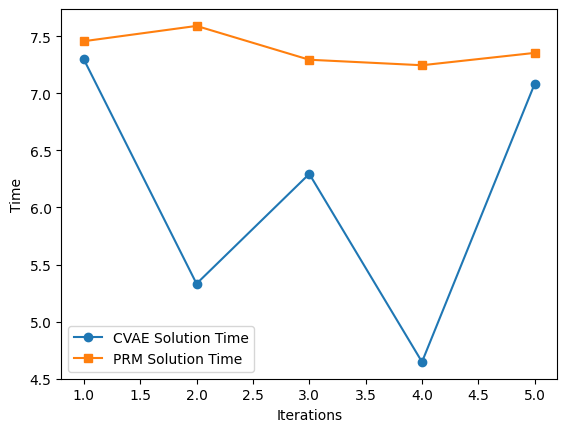

In [36]:
# Plot the execution time comparision
plt.plot(iter, [t[0] for t in times], marker='o', label='CVAE Solution Time')
plt.plot(iter, [t[1] for t in times], marker='s', label='PRM Solution Time')
plt.xlabel('Iterations')
plt.ylabel('Time')
plt.legend()
plt.show()